In [0]:
# 순환드롭아웃
# 스태킹 순환 층
# 양방향 순환 층

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
data_dir = '/content/drive/My Drive/dataset/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header) # columns
print(len(lines)) # 줄 개수임.

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
len(header)

15

In [0]:
# 420551 전체를 넘파이 배열로 바꿈
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]] # 0번은 datatime
  float_data[i, :] = values

In [7]:
float_data.shape

(420551, 14)

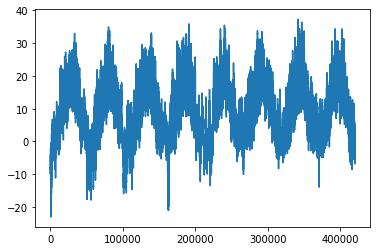

In [8]:
# 시간에 따른 섭씨 그래프
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

In [9]:
# 온도에 주기성이 있다는 것을 알 수 있음
# 기간을 줄여서 10일만 보자
# 10분마다 데이터가 있으니 
10 * 6 * 24

1440

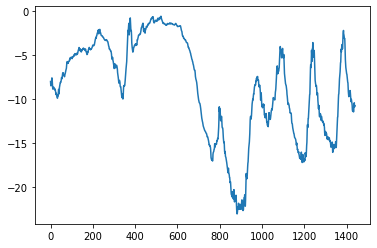

In [10]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [0]:
# 겨울인듯.
# 연간 데이터 주기는 보기 쉽지만 하루하루 데이터는 불안정함
# 일자별로 예측할 수 있을까?

# Preparing the data
## lookback = 1440
## steps = 6
## delay = 144

In [0]:
float_data.shape

In [0]:
# train만 우리는 관측할 수 있으니까 train 기준으로 정해줌
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
# data = 위에서 정규화한 데이터
# lookback = 입력 타임스텝
# delay = 미래 타임스텝
# min_index, max_index = 추출할 타임스텝의 범위를 지정하기 위한 data 배열 인덱스
# batch_size = 배치의 샘플 수
# step = 샘플링 타임스텝 간격(10분당 1이니까 1시간에 6)

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None: # test가 여기 해당
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle: # train이 여기 해당
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step) # 190개가 나옴
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
# data = 위에서 정규화한 데이터
# lookback = 입력 타임스텝
# delay = 미래 타임스텝
# min_index, max_index = 추출할 타임스텝의 범위를 지정하기 위한 data 배열 인덱스
# batch_size = 배치의 샘플 수
# step = 샘플링 타임스텝 간격(10분당 1이니까 1시간에 6)

In [0]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [18]:
val_steps, test_steps

(769, 930)

In [19]:
# 위의 거를 쓰기 전에 내일이 오늘과 온도가 똑같다고 예측을 해보자
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [0]:
0.29 * std[1]

2.5672247338393395

In [0]:
# 위 값에 표준편차를 곱하면 섭씨 2.5도

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 1.3429 - val_loss: 0.7068
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4101 - val_loss: 0.3375
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2886 - val_loss: 0.2960
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2644 - val_loss: 0.3217
Epoch 5/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2500 - val_loss: 0.3055
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2411 - val_loss: 0.3078
Epoch 7/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2360 - val_loss: 0.3135
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2295 - val_loss: 0.3281
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2264 - val_loss: 0.3149
Epoch 10/20
500/500 [==============================] - 14s 28ms/step - loss: 0.222

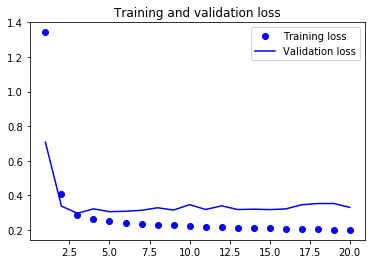

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 특정한 종류의 간단한 모델을 찾도록 하드코딩되지 않았다면 모델 파라미터를 학습하는 방법은
# 간단한 문제를 위한 간단한 해결책을 찾지 못할 수 있음

In [20]:
# GRU
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Using TensorFlow backend.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





500/500 [==============================] - 235s 470ms/step - loss: 0.3084 - val_loss: 0.2690
Epoch 2/20
500/500 [==============================] - 228s 456ms/step - loss: 0.2816 - val_loss: 0.2671
Epoch 3/20
500/500 [==============================] - 231s 463ms/step - loss: 0.2738 - val_loss: 0.2635
Epoch 4/20
500/500 [==============================] - 235s 470ms/step - loss: 0.2690 - val_loss: 0.2661
Epoch 5/20
500/500 [==============================] - 229s 458ms/step - loss: 0.2652 - val_loss: 0.2694
Epoch 6/20
500/500 [==============================] - 226s 453ms/step - loss: 0.2592 - val_loss: 0.2725
Epoch 7/20
500/500 [==============================] - 229s 458ms/step - loss: 0.2565 - val_loss: 0.2740
Epoch 8/20
500/500 [==============================] - 232s 464ms/step - loss: 0.2495 - val_loss: 0.2823
Epoch 9/20
500/500 [==============================] - 227s 454

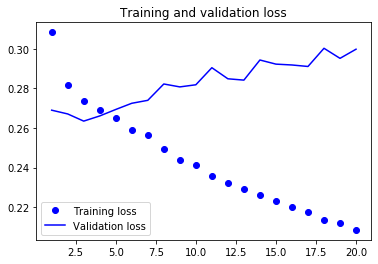

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 여기서 드롭아웃을 쓰려면 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 함

In [0]:
# dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동소숫값
# recurrent_dropout은 순환상태의 드롭아웃 비율을 정함

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout = 0.2,
                     recurreunt_dropout = 0.2,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500,
                              epochs= 40, validation_data = val_gen,
                              validation_steps = val_steps)

TypeError: ignored

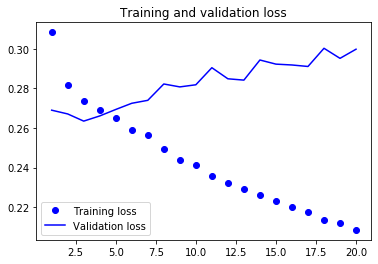

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Stacking recurrent layer

In [0]:
# 과대적합은 줄어든 것 같으니 과대적합이 일어날 때지 네트워크를 늘려보자
# 순환층을 차례대로 쌓으려면 모든 중간층은 마지막 타임스텝 출력이 아니라 전체 시퀀스를 출력
# 해야함.
# return_sequences = True

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

NameError: ignored

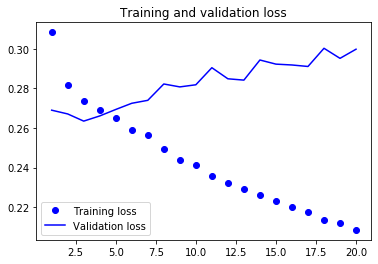

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
## 층을 추가한만큼 도움이 되지 않았음. 네트워크의 용량을 늘리는 게 큰 도움이 안 되는 듯

In [0]:
# 최근 타입스텝을 먼저 나오도록 해서 계산해보자.
# yield samples[:, ::-1, :], targets만 하면 됨

In [0]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 240s 481ms/step - loss: 0.4790 - val_loss: 0.4842
Epoch 2/20
500/500 [==============================] - 238s 476ms/step - loss: 0.4499 - val_loss: 0.4800
Epoch 3/20
500/500 [==============================] - 239s 479ms/step - loss: 0.4114 - val_loss: 0.4642
Epoch 4/20
277/500 [===============>..............] - ETA: 1:24 - loss: 0.3857

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 최근에 가까운 날씨일수록 오래된 데이터 포인트보다 예측에 유용함
# 그래서 안 나온듯
# 하지만 단어에 있어서 문장의 중요성은 최근 같은 것에 영향을 받지 않음
# 이전에 했던 LSTM IMDB에 적용해 보자

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [0]:
# 시간순서대로 한 것과 비슷한 결과를 얻는다.
#  언어를 이해하는 데 단어의 순서는 중요하지만 결정적이지는 않다를 알 수 있음

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

In [0]:
# Bidirectional 층을 받아서 양방향 RNN을 만들고 하나는 시간순, 하나는 반대시간으로 처리해보자.

In [0]:
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

In [0]:
# 과대적합이 일찍 일어남, 양방향 순환은 단방향 LSTM보다 모델 파라미터가 두 배 많아서 그럼
# 규제를 추가하자

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)